In [ ]:
cd drive/My\ Drive/ML_hw

/content/drive/My Drive/ML_hw


In [ ]:
pwd

'/content/drive/My Drive/ML_hw'

In [1]:
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

np.random.seed(0)

In [146]:
def gen_n_data():
  cov = np.array([[1., 0.], [0., 1.]])

  x_p = np.random.multivariate_normal([2., 3.], cov, 200)
  x_n = np.random.multivariate_normal([5., 6.], cov, 800)
  
  x = np.vstack((x_p, x_n))
  y = np.vstack(([[1.] for _ in range(200)], [[0.] for _ in range(800)]))

  return np.hstack((x, y))

In [147]:
xy = gen_n_data()
np.random.shuffle(xy)
xy
# y = y.reshape((len(y), 1))

array([[3.69712787, 5.99279162, 0.        ],
       [2.08133752, 0.9698662 , 1.        ],
       [1.32731876, 4.70899144, 1.        ],
       ...,
       [4.70675396, 6.6508469 , 0.        ],
       [6.58654043, 6.43349728, 0.        ],
       [4.43449541, 6.4438758 , 0.        ]])

In [151]:
def draw(x, y, m='.'):
  p = []
  n = []
  for i in range(len(x)):
    if y[i] > 0.5:
      p.append(x[i])
    else:
      n.append(x[i])
  p = np.asarray(p)
  n = np.asarray(n)
  if p.size > 0:
    plt.scatter(p[:, 0], p[:, 1], c='b', marker=m)
  if n.size > 0:
    plt.scatter(n[:, 0], n[:, 1], c='r', marker=m)

In [152]:
test_x, test_y = xy[:200, :2], xy[:200, 2:]
val_x, val_y = xy[200:400, :2], xy[200:400, 2:]
x, y = xy[400:, :2], xy[400:, 2:]

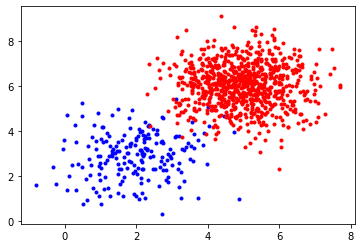

In [153]:
draw(x, y, '.')
draw(val_x, val_y, '.')
draw(test_x, test_y, '.')
plt.savefig('5_raw.svg')

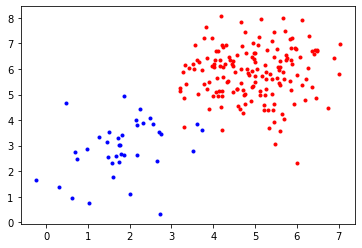

In [154]:
draw(val_x, val_y, '.')

In [155]:
x.shape, y.shape

((600, 2), (600, 1))

In [156]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD,Adam

In [157]:
from keras import backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
 
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [158]:
def t(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    return true_positives
def tt(y_true, y_pred):
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return possible_positives

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Train on 600 samples, validate on 200 samples
Epoch 1/200
600/600 [==============================] - 0s 223us/step - loss: 0.3209 - t: 12.5000 - tt: 12.5000 - accuracy: 0.2083 - recall: 1.0000 - precision: 0.2083 - f1: 0.3431 - val_loss: 0.3273 - val_t: 9.5000 - val_tt: 9.5000 - val_accuracy: 0.1900 - val_recall: 0.7500 - val_precision: 0.1484 - val_f1: 0.2440
Epoch 2/200
600/600 [==============================] - 0s 39us/step - loss: 0.3180 - t: 12.4000 - tt: 12.5000 - accuracy: 0.2067 - recall: 0.9957 - pre

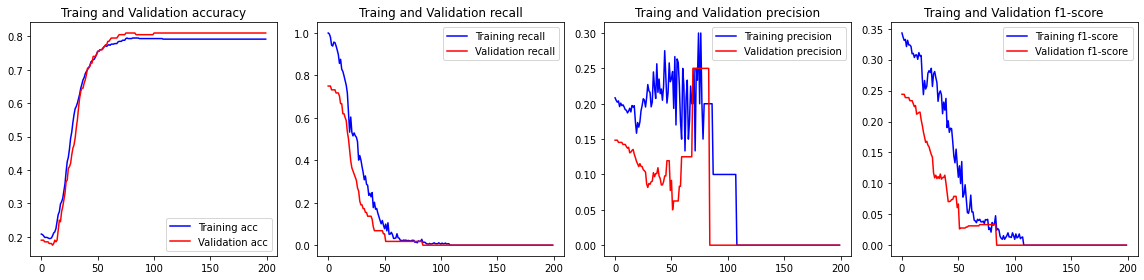

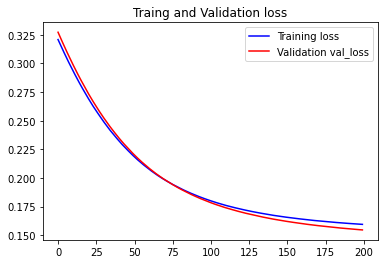

In [198]:
model1 = Sequential()

model1.add(Dense(10, input_shape=((2,)), activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6)
model1.compile(loss='mse', optimizer=sgd, metrics=[t, tt, 'accuracy', recall, precision, f1])

print(model1.summary())

history = model1.fit(x, y, validation_data=(val_x, val_y), epochs=200, batch_size=64)

epochs=range(len(history.history['accuracy']))

fig = plt.figure(figsize=(16, 4))
# ax = fig.add_subplot(111)
# ax.set_aspect('equal', adjustable='box')


plt.subplot(141)

plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
plt.title('Traing and Validation accuracy')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(142)
plt.plot(epochs,history.history['recall'],'b',label='Training recall')
plt.plot(epochs,history.history['val_recall'],'r',label='Validation recall')
plt.title('Traing and Validation recall')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(143)
plt.plot(epochs,history.history['precision'],'b',label='Training precision')
plt.plot(epochs,history.history['val_precision'],'r',label='Validation precision')
plt.title('Traing and Validation precision')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(144)
plt.plot(epochs,history.history['f1'],'b',label='Training f1-score')
plt.plot(epochs,history.history['val_f1'],'r',label='Validation f1-score')
plt.title('Traing and Validation f1-score')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)
plt.savefig('5_1_result.svg')




plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.savefig('5_1_loss.svg')






In [199]:
def convert(a):
  return np.asarray(a > 0.5, dtype=np.float64)

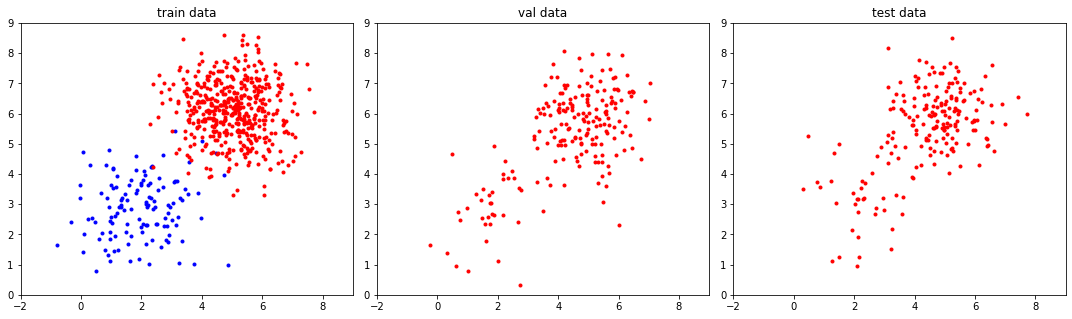

In [200]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

y_pr = model1.predict(x)

plt.subplot(131)
plt.title('train data')
plt.xlim([-2, 9])
plt.ylim([0, 9])
draw(x,y)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

y_pr_val = model1.predict(val_x)
plt.subplot(132)
plt.xlim([-2, 9])
plt.ylim([0, 9])
plt.title('val data')
draw(val_x, y_pr_val)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

y_pr_test = model1.predict(test_x)
plt.subplot(133)
plt.xlim([-2, 9])
plt.ylim([0, 9])
plt.title('test data')
draw(test_x, y_pr_test)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.savefig('5_1_s.svg')

In [201]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [202]:
def roc(y_true, y_pr_):
  # 为每个类别计算ROC曲线和AUC

  fpr, tpr, _ = roc_curve(y_true.flatten(), y_pr_.flatten(), pos_label=1)
  print(fpr, tpr, _)
  roc_auc = auc(fpr, tpr)
  # fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
  # roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

  # plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  # plt.show()

In [ ]:
y_pr

(600, 1) (600, 1)
(200, 1) (200, 1)
[0.         0.         0.         0.00210526 0.00210526 0.00631579
 0.00631579 0.01052632 0.01052632 0.01473684 0.01473684 0.01684211
 0.01684211 0.02736842 0.02736842 0.02947368 0.02947368 0.03368421
 0.03368421 0.03578947 0.03578947 0.04       0.04       0.04210526
 0.04210526 0.04842105 0.04842105 0.05263158 0.05263158 0.05894737
 0.05894737 0.06315789 0.06315789 0.06947368 0.06947368 0.07157895
 0.07157895 0.07368421 0.07368421 0.07789474 0.07789474 0.09473684
 0.09473684 0.10105263 0.10105263 0.10526316 0.10526316 0.11157895
 0.11157895 0.13052632 0.13052632 0.13684211 0.13684211 0.13894737
 0.13894737 0.14315789 0.14315789 0.15578947 0.15578947 0.15789474
 0.15789474 0.16       0.16       0.16631579 0.16631579 0.16842105
 0.16842105 0.17684211 0.17684211 0.17894737 0.17894737 0.18105263
 0.18105263 0.18315789 0.18315789 0.18526316 0.18526316 0.18947368
 0.18947368 0.19368421 0.19368421 0.22315789 0.22315789 0.22526316
 0.22526316 0.23789474 0.2

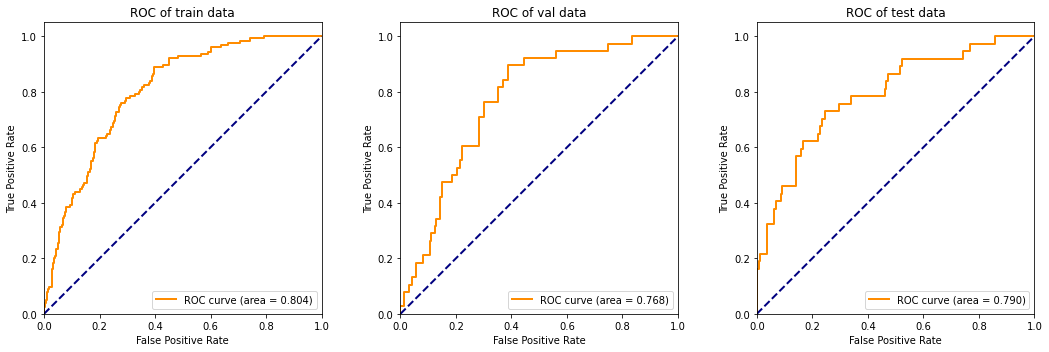

In [204]:
print(y.shape, y_pr.shape)
print(val_y.shape, y_pr_val.shape)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')


plt.subplot(131)
plt.title('ROC of train data')
roc(y, y_pr)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(132)
plt.title('ROC of val data')
roc(val_y, y_pr_val)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(133)
plt.title('ROC of test data')
roc(test_y, y_pr_test)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('5_1_auc.svg')

In [205]:
y_pr_test

array([[0.2507396 ],
       [0.37684876],
       [0.2514095 ],
       [0.28148186],
       [0.27297974],
       [0.23805729],
       [0.2583629 ],
       [0.2738879 ],
       [0.2430434 ],
       [0.3236128 ],
       [0.29015636],
       [0.28359032],
       [0.32574487],
       [0.27372032],
       [0.2728818 ],
       [0.2668661 ],
       [0.24480033],
       [0.25075197],
       [0.2554937 ],
       [0.2595869 ],
       [0.26993766],
       [0.2563401 ],
       [0.2685828 ],
       [0.27126902],
       [0.25801986],
       [0.24694014],
       [0.30847985],
       [0.24952936],
       [0.27619308],
       [0.25318056],
       [0.26235998],
       [0.34880775],
       [0.28657377],
       [0.24808255],
       [0.2394301 ],
       [0.24966186],
       [0.2560462 ],
       [0.2932521 ],
       [0.27124792],
       [0.26104692],
       [0.24404714],
       [0.25467327],
       [0.25053567],
       [0.28149277],
       [0.25733906],
       [0.26639295],
       [0.28821003],
       [0.258

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_102 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
None
Train on 600 samples, validate on 200 samples
Epoch 1/200
600/600 [==============================] - 0s 232us/step - loss: 0.4760 - t: 12.5000 - tt: 12.5000 - accuracy: 0.2083 - recall: 1.0000 - precision: 0.2057 - f1: 0.3379 - val_loss: 0.4861 - val_t: 9.5000 - val_tt: 9.5000 - val_accuracy: 0.1900 - val_recall: 0.7500 - val_precision: 0.1484 - val_f1: 0.2440
Epoch 2/200
600/6

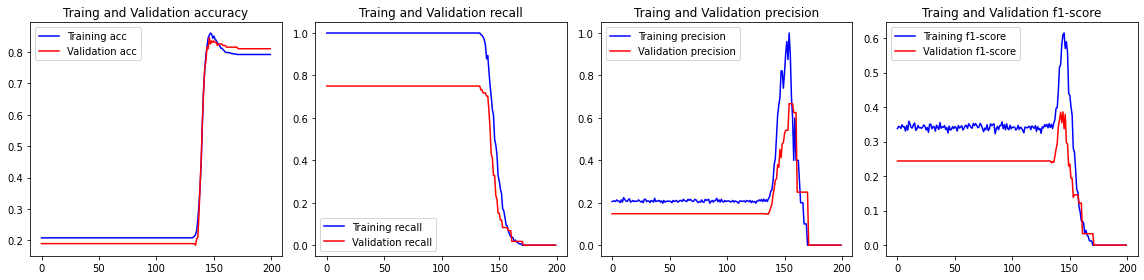

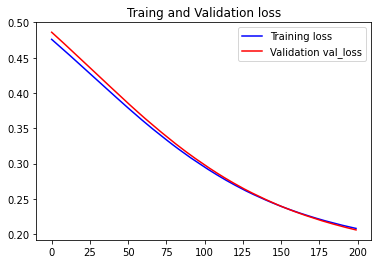

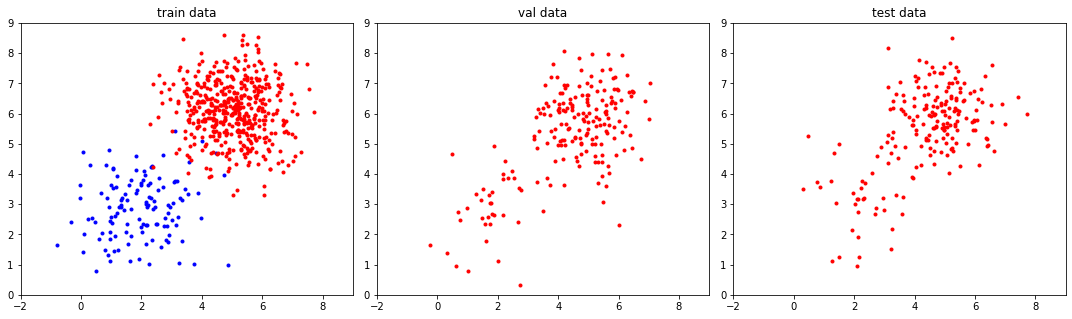

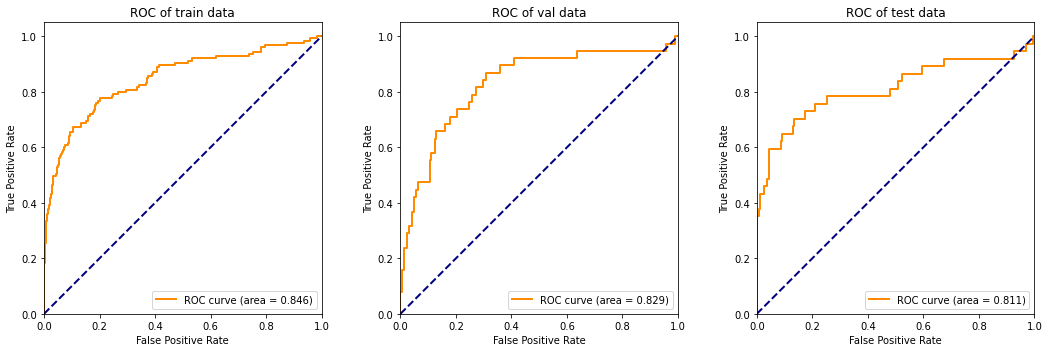

In [211]:
model1 = Sequential()

model1.add(Dense(10, input_shape=((2,)), activation='sigmoid'))
model1.add(Dense(10, activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6)
model1.compile(loss='mse', optimizer=sgd, metrics=[t, tt, 'accuracy', recall, precision, f1])

print(model1.summary())

history = model1.fit(x, y, validation_data=(val_x, val_y), epochs=200, batch_size=64)

epochs=range(len(history.history['accuracy']))

fig = plt.figure(figsize=(16, 4))
# ax = fig.add_subplot(111)
# ax.set_aspect('equal', adjustable='box')


plt.subplot(141)

plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
plt.title('Traing and Validation accuracy')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(142)
plt.plot(epochs,history.history['recall'],'b',label='Training recall')
plt.plot(epochs,history.history['val_recall'],'r',label='Validation recall')
plt.title('Traing and Validation recall')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(143)
plt.plot(epochs,history.history['precision'],'b',label='Training precision')
plt.plot(epochs,history.history['val_precision'],'r',label='Validation precision')
plt.title('Traing and Validation precision')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)

plt.subplot(144)
plt.plot(epochs,history.history['f1'],'b',label='Training f1-score')
plt.plot(epochs,history.history['val_f1'],'r',label='Validation f1-score')
plt.title('Traing and Validation f1-score')
plt.legend()
plt.tight_layout()
# ax = plt.gca()
# ax.set_aspect(1)
plt.savefig('5_2_result.svg')




plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.savefig('5_2_loss.svg')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

y_pr = model1.predict(x)

plt.subplot(131)
plt.title('train data')
plt.xlim([-2, 9])
plt.ylim([0, 9])
draw(x,y)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

y_pr_val = model1.predict(val_x)
plt.subplot(132)
plt.xlim([-2, 9])
plt.ylim([0, 9])
plt.title('val data')
draw(val_x, y_pr_val)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

y_pr_test = model1.predict(test_x)
plt.subplot(133)
plt.xlim([-2, 9])
plt.ylim([0, 9])
plt.title('test data')
draw(test_x, y_pr_test)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('5_2_s.svg')
print(y.shape, y_pr.shape)
print(val_y.shape, y_pr_val.shape)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')


plt.subplot(131)
plt.title('ROC of train data')
roc(y, y_pr)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(132)
plt.title('ROC of val data')
roc(val_y, y_pr_val)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(133)
plt.title('ROC of test data')
roc(test_y, y_pr_test)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('5_2_roc.svg')

[0.         0.         0.         0.00210526 0.00210526 0.00631579
 0.00631579 0.01052632 0.01052632 0.01263158 0.01263158 0.01894737
 0.01894737 0.02315789 0.02315789 0.02736842 0.02736842 0.02947368
 0.02947368 0.03578947 0.03578947 0.04421053 0.04421053 0.04631579
 0.04631579 0.04842105 0.04842105 0.05052632 0.05052632 0.05263158
 0.05263158 0.05473684 0.05473684 0.06315789 0.06315789 0.06736842
 0.06736842 0.07368421 0.07368421 0.08631579 0.08631579 0.09052632
 0.09052632 0.09473684 0.09473684 0.09684211 0.09684211 0.10736842
 0.10736842 0.10947368 0.10947368 0.13052632 0.13052632 0.13263158
 0.13263158 0.13684211 0.13684211 0.14315789 0.14315789 0.15578947
 0.15578947 0.15789474 0.15789474 0.16210526 0.16210526 0.17052632
 0.17052632 0.17894737 0.17894737 0.18315789 0.18315789 0.18736842
 0.18736842 0.19157895 0.19157895 0.19578947 0.19578947 0.2
 0.2        0.21894737 0.21894737 0.22526316 0.22526316 0.23157895
 0.23157895 0.23368421 0.23368421 0.23578947 0.23578947 0.24210526
 0

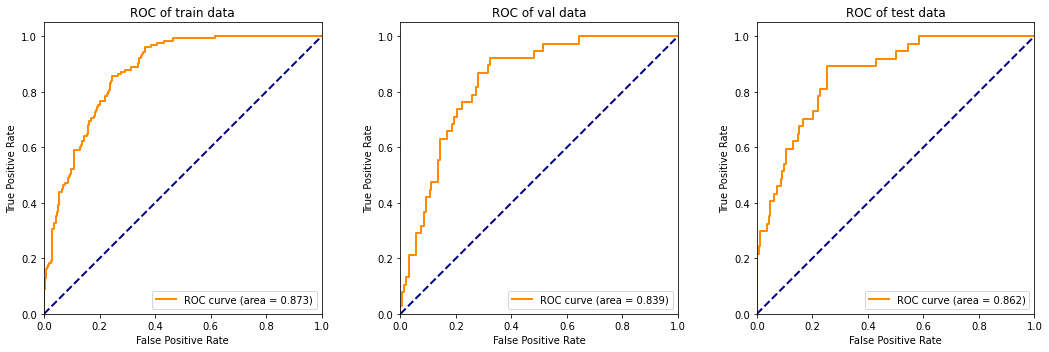

In [194]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')


plt.subplot(131)
plt.title('ROC of train data')
roc(y, y_pr)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(132)
plt.title('ROC of val data')
roc(val_y, y_pr_val)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)

plt.subplot(133)
plt.title('ROC of test data')
roc(test_y, y_pr_test)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('5_2_roc.svg')